## Exploration - EDA

use the learned representation to develop a visualization of the items and users, e.g., using T-SNE or UMAP. The visualization should somehow integrate additional information (features, metadata, or genre tags) to illustrate how items are distributed in the learned space.

In [1]:
#pip install --pre umap-learn

### Setup packages and enviornment

In [2]:
# import pyspark as spark

import os
import sqlite3

import pandas as pd
import numpy as np
import itertools
from collections import Counter

from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
import umap
import umap.plot
import matplotlib.pyplot as plt
import time
import datetime

# from IPython.display import display
# import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [3]:
import dask
import dask.bag as db
import dask.dataframe as dd
from distributed import Client
from dask_jobqueue import SLURMCluster

In [4]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution
LOCAL = True

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='4GB', cores=2, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)

display(client)

Client Scheduler: tcp://127.0.0.1:40649 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 32.00 GiB


In [5]:
# Setup and configure spark session
spark = SparkSession.builder \
  .master("local") \
  .appName("parquet_example") \
  .config('spark.sql.execution.arrow.pyspark.enabled', True) \
  .config('spark.sql.session.timeZone', 'UTC') \
  .config('spark.driver.memory','32G') \
  .config('spark.ui.showConsoleProgress', True) \
  .config('spark.sql.repl.eagerEval.enabled', True) \
  .getOrCreate()

# Enable Arrow-based columnar data
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

### Load data and data cleaning

#### Import data

In [6]:
# Read data from hdfs
df_val = spark.read.parquet('/scratch/work/courses/DSGA1004-2021/MSD/cf_validation.parquet')
df_test = spark.read.parquet('/scratch/work/courses/DSGA1004-2021/MSD/cf_test.parquet')
df_train = spark.read.parquet('/scratch/work/courses/DSGA1004-2021/MSD/cf_train_new.parquet')
#spark.read.parquet('/scratch/work/courses/DSGA1004-2021/MSD/AdditionalFiles')

# Union all training+val+test data
df = df_test.unionAll(df_val).unionAll(df_train)

In [7]:
# Read track metadata
conn = sqlite3.connect("/scratch/work/courses/DSGA1004-2021/MSD/AdditionalFiles/track_metadata.db")
cur = conn.cursor()
df_meta = pd.read_sql_query("SELECT * FROM songs", conn)
cur.close()
conn.close()

In [8]:
# read artist data
# There are already many information readily available in the metadata about artists
conn = sqlite3.connect("/scratch/work/courses/DSGA1004-2021/MSD/AdditionalFiles/artist_term.db")
cur = conn.cursor()
df_artterm = pd.read_sql_query("SELECT * FROM artist_term", conn)
df_artmbt = pd.read_sql_query("SELECT * FROM artist_mbtag", conn)
# df_mbt = pd.read_sql_query("SELECT * FROM mbtags", conn)
# df_term = pd.read_sql_query("SELECT * FROM terms", conn)
# df_artist = pd.read_sql_query("SELECT * FROM artists", conn)
cur.close()
conn.close()

In [9]:
# read tag data
conn = sqlite3.connect("/scratch/work/courses/DSGA1004-2021/MSD/AdditionalFiles/lastfm_tags.db")
cur = conn.cursor()
df_tags = pd.read_sql_query("SELECT * FROM tags", conn)
df_tidtag = pd.read_sql_query("SELECT * FROM tid_tag", conn)
df_tid = pd.read_sql_query("SELECT * FROM tids", conn)
cur.close()
conn.close()

In [10]:
# read song data
# I don't think there are any tags/ features related to a song_id readily available in the /AdditionalFiles?

In [11]:
# rename keys for table merging
df_tidtag.columns = ['tid_num','tag_num','val']
df_tags.index.names = ['tag_num']
df_tid.index.names = ['tid_num']
df_meta.rename(columns={'track_id':'tid'}, inplace=True)

#### Cleaning artist data

In [12]:
df_artterm = pd.DataFrame(df_artterm.groupby('artist_id')['term'].apply(list))

In [13]:
# Many artists have multiple mbtags and many have none
# Total # of artists with at least one mbtag: 8838
df_artmbt = pd.DataFrame(df_artmbt.groupby('artist_id')['mbtag'].apply(list))

In [14]:
df_artists = pd.merge(
    df_artterm,
    df_artmbt,
    how = 'outer',
    on = 'artist_id',
    sort = False)
# rename columns
df_artists.columns = ['artist_term', 'artist_mbtag']

#### Cleaning genre tag data

In [15]:
# Since pandas df index start from 0, 
# we subtract both track_id and tag_id by 1 to match the default index of pandas df
df_tidtag['tid_num'] -= 1
df_tidtag['tag_num'] -= 1

In [16]:
# merge tags and track id
df_all = pd.merge(
    df_tidtag,
    df_tags,
    how = 'outer',
    on = 'tag_num',
    sort = False)

df_all = pd.merge(
    df_all,
    df_tid,
    how = 'outer',
    on = 'tid_num',
    sort = False)

In [17]:
# get a list of [(genre, val(in %))] pairs for each track
df_all = pd.DataFrame(df_all.groupby('tid')[['tag', 'val']].apply(lambda g: dict(map(tuple, g.values.tolist()))))

In [18]:
# rename the column
df_all.columns = ['track_genre_val']

#### Merging artist, genre tag data with metadata

In [19]:
# merge metadata with track tags
df_meta = pd.merge(
    df_meta,
    df_all,
    how = 'outer',
    on = 'tid',
    sort = False)

In [20]:
# merge metadata with artist mbtag and term
df_meta = pd.merge(
    df_meta,
    df_artists,
    how = 'outer',
    on = 'artist_id',
    sort = False)

In [21]:
# rename column for ease of merging
df_meta.rename(columns={'tid':'track_id'}, inplace=True)

#### Sampling and cleaning training+val+test data for plotting

In [22]:
# random sampling 400k samples from the entire dataset
# df_train.toPandas induces error because df_train too large (2m pyspark df)
df_samp = df.sample(False, 0.1, seed=66).limit(400000)

In [23]:
# convert to pandas df
samp_array = df_samp.collect()
df_samp = df_samp.toPandas()

In [24]:
# merge to get df for plot
df_plot = pd.merge(
    df_meta,
    df_samp,
    how = 'inner',
    on = 'track_id',
    sort = False)

In [25]:
# drop unnecessary column
df_plot = df_plot.drop('__index_level_0__', axis = 1)
# replace 0 release year with nan
df_plot['year'] = df_plot['year'].replace(['0', 0], np.nan)
df_plot

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_genre_val,artist_term,artist_mbtag,user_id,count
0,TRMRSPR128F1486162,Friends (LP Version),SOIASSQ12A6D4FA5A4,Whipped,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussycat,287.81669,0.649822,0.394032,NaN,"{'80s': 25.0, 'rock': 100.0, 'hard rock': 100....","[heavy metal, industrial metal, hard rock, gla...",NaN,f499a469fdf0f01a114eff3ffc45f07eb1038211,1
1,TRWMLGY128F148A1C3,Shooting You Down (LP Version),SOYXZOF12A6D4F96AC,Rhino Hi-Five: Faster Pussycat,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussycat,227.94404,0.649822,0.394032,NaN,"{'rock': 50.0, 'hard rock': 100.0, 'hair metal...","[heavy metal, industrial metal, hard rock, gla...",NaN,565a013a24c2ec710ff6611187389b6b92251bfb,1
2,TRWBHIN128F425A381,Arizona Indian Doll,SOMLCSC12A8C139300,Between The Valley Of The Ultra Pussy,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussycat,265.16853,0.649822,0.394032,1989.0,"{'80s': 27.0, 'rock': 63.0, 'rock n roll': 18....","[heavy metal, industrial metal, hard rock, gla...",NaN,5411bf5ca6fa50a504bce1ef7d44c5f2ae4638ca,1
3,TRHZAVC128F148A1C4,House Of Pain (LP Version),SOSMFOK12A58A7FE92,Rhino Hi-Five: Faster Pussycat,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussycat,344.65914,0.649822,0.394032,NaN,"{'70s': 0.0, '80s': 66.0, 'rock': 100.0, 'meta...","[heavy metal, industrial metal, hard rock, gla...",NaN,8b037ca0e5d30e7ef25b5463b9c82973f5c750ea,1
4,TRHZAVC128F148A1C4,House Of Pain (LP Version),SOSMFOK12A58A7FE92,Rhino Hi-Five: Faster Pussycat,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussycat,344.65914,0.649822,0.394032,NaN,"{'70s': 0.0, '80s': 66.0, 'rock': 100.0, 'meta...","[heavy metal, industrial metal, hard rock, gla...",NaN,297fe67d7b1d8a8b1cdb78ab5239203a39a2a3a0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,TRYDBBR128F9302860,Rich In Paradise,SOUMVOX12AB018298E,The Very Best of Euphoric Dance Breakdown 2009,AR9O38K1187B992141,d78ef6fc-df19-4ba2-8336-cbb1d5aa7777,FPI Project,348.10730,0.478736,0.361698,1990.0,"{'pop': 8.0, 'cool': 0.0, '90s': 41.0, 'female...","[italian disco, europop, new beat, disco, deep...",NaN,ef680f70b767dddfc108654300217e0940e82692,10
399996,TRYXGDO128F932A05C,Save me from my curse (cursed by unterart),SOVWYWX12AB0184239,Save Me From My Curse,ARUTHLE11F4C842002,bdf0ea1e-48df-4445-a6c6-8ab5913bd9c3,Rabia Sorda,287.58159,0.593110,0.547334,NaN,"{'industrial': 66.0, 'Gothic': 33.0, 'dark ele...","[hip hop, pop, indie rock, indie, guitar]",NaN,34ed37fd8aa3d83a6df5ee8e728922087ac98e45,3
399997,TRYXGDO128F932A05C,Save me from my curse (cursed by unterart),SOVWYWX12AB0184239,Save Me From My Curse,ARUTHLE11F4C842002,bdf0ea1e-48df-4445-a6c6-8ab5913bd9c3,Rabia Sorda,287.58159,0.593110,0.547334,NaN,"{'industrial': 66.0, 'Gothic': 33.0, 'dark ele...","[hip hop, pop, indie rock, indie, guitar]",NaN,2a28525fe64e492b81184d22877cca8220bb157c,1
399998,TRYXGDO128F932A05C,Save me from my curse (cursed by unterart),SOVWYWX12AB0184239,Save Me From My Curse,ARUTHLE11F4C842002,bdf0ea1e-48df-4445-a6c6-8ab5913bd9c3,Rabia Sorda,287.58159,0.593110,0.547334,NaN,"{'industrial': 66.0, 'Gothic': 33.0, 'dark ele...","[hip hop, pop, indie rock, indie, guitar]",NaN,55b1f94b29832d7edebc13ee2df081377ec0427a,1


### Simple EDA: matplotlib + seaborn pairplot

In this section, we will analyze the data and decide which genre/ tag to be assigned to an artist/ track. One artist will be resulted in one tag and one track will be associated with one genre. We do this single assignment for the ease of UMAP learning.

In [26]:
df_plot.describe()

,duration,artist_familiarity,artist_hotttnesss,year,count
count,400000.000000,400000.000000,400000.000000,318970.000000,400000.000000
mean,248.983683,0.726252,0.543675,2000.429175,2.990050
std,98.048313,0.133847,0.146341,9.887722,6.329269
min,0.678730,-1.000000,0.000000,1927.000000,1.000000
25%,198.974240,0.642352,0.451360,1997.000000,1.000000
50%,234.004440,0.749180,0.530413,2004.000000,1.000000
75%,277.864040,0.830885,0.601436,2007.000000,3.000000
max,3024.665670,1.000000,1.082503,2011.000000,451.000000


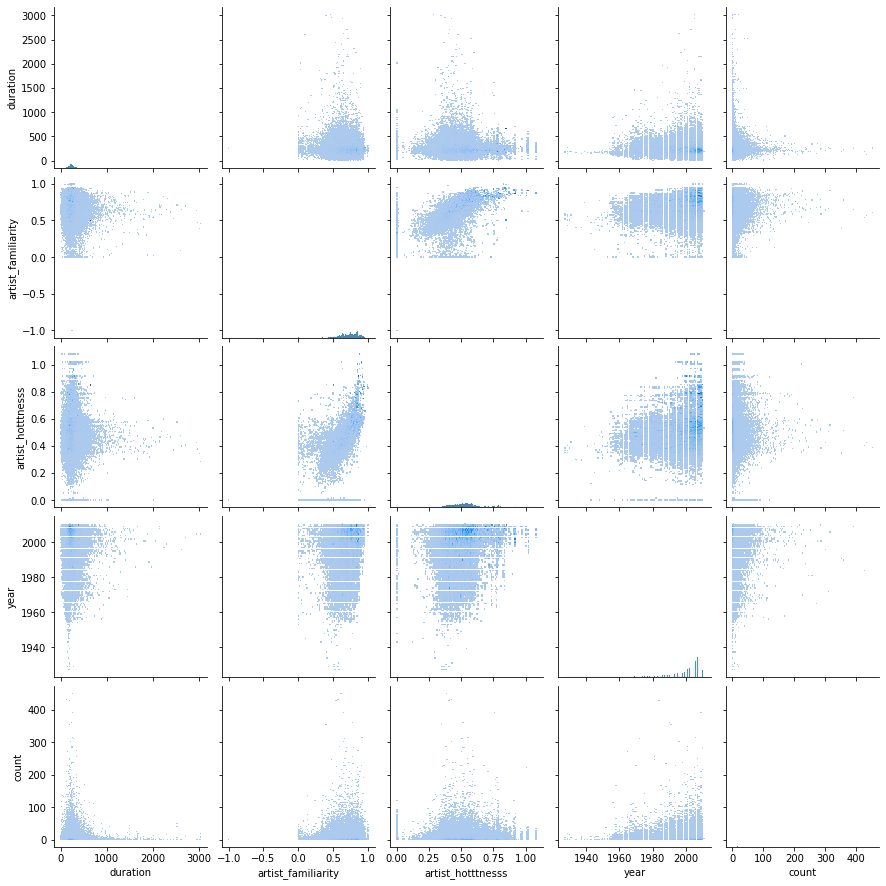

In [27]:
import seaborn as sns
sns.pairplot(df_plot, kind = 'hist') #hue?

#### Artist vs genre tags eda

This is useful for selecting the most descriptive artist genre tag.

Each artist will be assigned with a genre tag that has the highest appearance rank among all artists. The rank of a genre is calculated from the total number of times it appears in the entire MSD dataset. (Assumption made: the more times an artist genre appears the hotter/ more popular this genre is)

This would introduce a somewhat popularity bias but still would be descriptive for a specific artist

In [28]:
# most listened to by different users (1 user = 1 count; any more counts by the same user are not calculated)
most_artist = pd.DataFrame(df_plot[["artist_name", "artist_id"]].value_counts(ascending = True))
most_artist.columns = ['count']
most_artist['rank'] = most_artist['count'].rank()

In [29]:
mostlistened_artist = pd.DataFrame(df_plot.groupby(['artist_name','artist_id'])['count'].apply(sum))\
                                    .sort_values('count', ascending = True)
mostlistened_artist['rank'] = mostlistened_artist['count'].rank()

In [30]:
most_artist_20 = most_artist.tail(20)
mostlistened_artist_20 = mostlistened_artist.tail(20)

Text(0.5, 1.0, 'top 20 artists listened the most times')

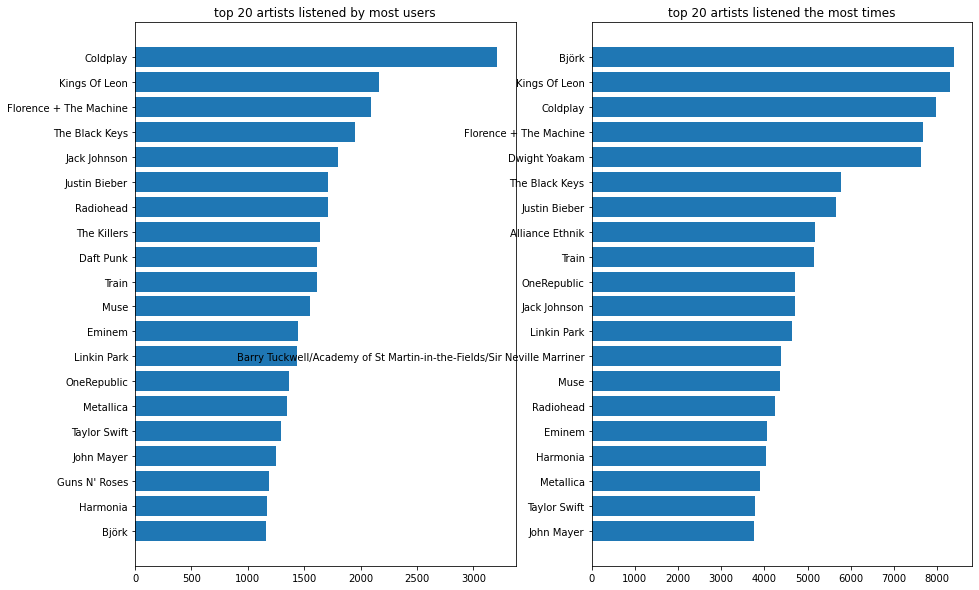

In [31]:
# side by side bar chart: most listened artists (by most users versus by most times)
x1, y1, x2, y2 = most_artist_20.index.get_level_values(0), most_artist_20['count'],\
                mostlistened_artist_20.index.get_level_values(0), mostlistened_artist_20['count']
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(121)
plt.barh(x1,y1)
plt.title('top 20 artists listened by most users')
ax = fig.add_subplot(122)
plt.barh(x2,y2)
plt.title('top 20 artists listened the most times')

##### Selecting artist tags (for artists with multiple tags)

In [32]:
df_plot['artist_term']

0         [heavy metal, industrial metal, hard rock, gla...
1         [heavy metal, industrial metal, hard rock, gla...
2         [heavy metal, industrial metal, hard rock, gla...
3         [heavy metal, industrial metal, hard rock, gla...
4         [heavy metal, industrial metal, hard rock, gla...
                                ...                        
399995    [italian disco, europop, new beat, disco, deep...
399996            [hip hop, pop, indie rock, indie, guitar]
399997            [hip hop, pop, indie rock, indie, guitar]
399998            [hip hop, pop, indie rock, indie, guitar]
399999    [pop, pop rock, urban, r&b, female vocalist, s...
Name: artist_term, Length: 400000, dtype: object

In [33]:
artist_term = list(df_plot['artist_term'].dropna())
artist_term = pd.DataFrame(list(itertools.chain(*artist_term)))
artist_term = pd.DataFrame(artist_term.value_counts().sort_values(ascending = True))
artist_term.columns = ['count']
artist_term['rank'] = artist_term.rank()

In [34]:
artist_mbtag = list(df_plot['artist_mbtag'].dropna())
artist_mbtag = pd.DataFrame(list(itertools.chain(*artist_mbtag)))
artist_mbtag = pd.DataFrame(artist_mbtag.value_counts().sort_values(ascending = True))
artist_mbtag.columns = ['count']
artist_mbtag['rank'] = artist_mbtag.rank()

In [35]:
artist_term_20 = artist_term.tail(20)
artist_mbtag_20 = artist_mbtag.tail(20)

Text(0.5, 1.0, 'top 20 mbtags of the most listened artists')

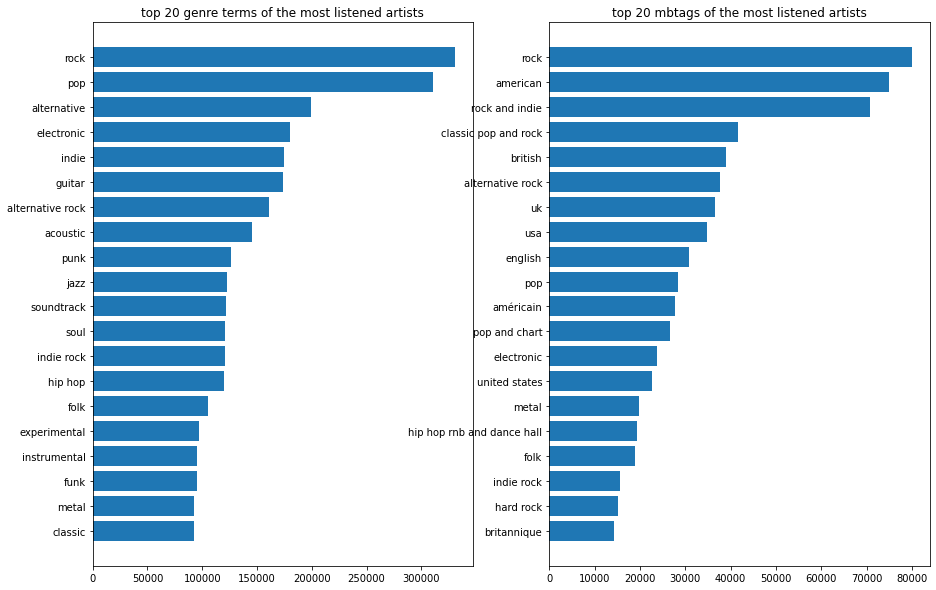

In [36]:
# side by side bar chart: top 20 artist term vs mbtags of most listened artists
x1, y1, x2, y2 = artist_term_20.index.get_level_values(0), artist_term_20['count'],\
                artist_mbtag_20.index.get_level_values(0), artist_mbtag_20['count']
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(121)
plt.barh(x1,y1)
plt.title('top 20 genre terms of the most listened artists')
ax = fig.add_subplot(122)
plt.barh(x2,y2)
plt.title('top 20 mbtags of the most listened artists')

#### Track analysis

This could also be used for selecting the most descriptive genre tag for a track

In [37]:
# most listened to by different users (1 user = 1 count; any more counts by the same user are not calculated)
most_track = pd.DataFrame(df_plot[["track_id", "title"]].value_counts(ascending = True))
most_track.columns = ['count']

In [38]:
mostlistened_track = pd.DataFrame(df_plot.groupby(["track_id", "title"])['count'].apply(sum))\
                                    .sort_values('count', ascending = True)

In [39]:
most_track_20 = most_track.tail(20)
mostlistened_track_20 = mostlistened_track.tail(20)

Text(0.5, 1.0, 'top 20 tracks listened the most times')

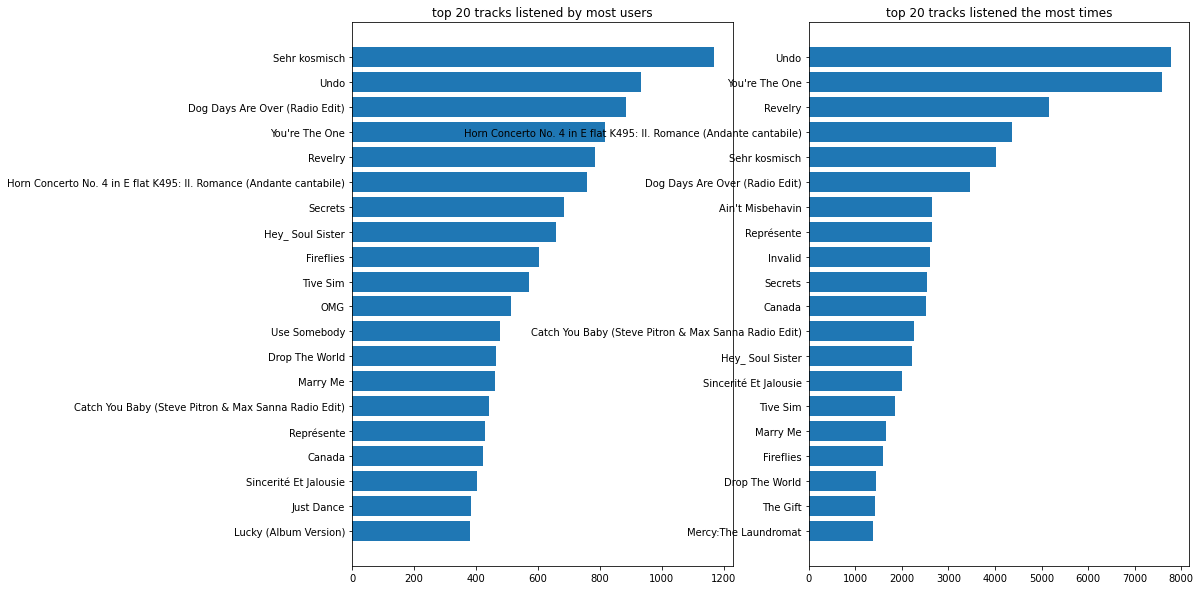

In [40]:
# side by side bar chart: most listened artists (by most users versus by most times)
x1, y1, x2, y2 = most_track_20.index.get_level_values(1), most_track_20['count'],\
                mostlistened_track_20.index.get_level_values(1), mostlistened_track_20['count']
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(121)
plt.barh(x1,y1)
plt.title('top 20 tracks listened by most users')
ax = fig.add_subplot(122)
plt.barh(x2,y2)
plt.title('top 20 tracks listened the most times')

##### A demograph of the number of times track being listend to

Most tracks are only listened to once or twice. 

In [41]:
# track versus count pie chart
# most track are only listend to by once or twice
times = [*range(1,20,1)]
times_full = [*range(1, max(mostlistened_track['count']), 1)]
times_listened_to_1, times_listened_to_2 = {}, {}
for time in times:
    times_listened_to_1[str(time)] = len(mostlistened_track[mostlistened_track['count'] == time])/ len(mostlistened_track)
for time in times_full:
    times_listened_to_2[str(time)] = len(mostlistened_track[mostlistened_track['count'] == time])/ len(mostlistened_track)

In [42]:
times_df_1 = pd.DataFrame(list(times_listened_to_1.items()),columns = ['times listened to','%'])
times_df_2 = pd.DataFrame(list(times_listened_to_2.items()),columns = ['times listened to','%'])

<AxesSubplot:>

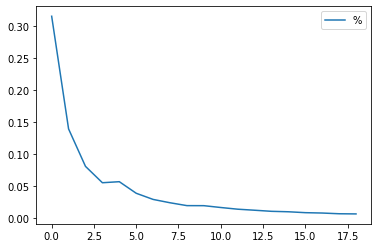

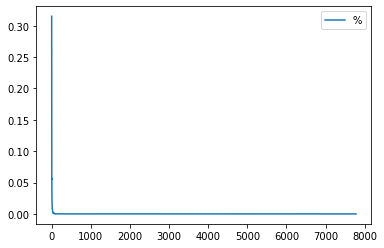

In [43]:
times_df_1.plot()
times_df_2.plot()

There is a clear decrease at range (1, 5) and there is almost no change in the range (1000, 8000) so we will binning the "number of times a track is listened to" by [1, 2, 3 - 5, 6-10, 11 - 49, 50 - 99, 101 - 1000, >1000]

In [44]:
df_times = {'Once': len(mostlistened_track[mostlistened_track['count'] == 1])/ len(mostlistened_track),
            'Twice': len(mostlistened_track[mostlistened_track['count'] == 2])/ len(mostlistened_track),
            '3 - 5': len(mostlistened_track[mostlistened_track['count'].between(3,5)])/ len(mostlistened_track),
            '6-10': len(mostlistened_track[mostlistened_track['count'].between(6,10)])/ len(mostlistened_track),
            '11-49': len(mostlistened_track[mostlistened_track['count'].between(11,49)])/ len(mostlistened_track),
            '50-99': len(mostlistened_track[mostlistened_track['count'].between(50,99)])/ len(mostlistened_track),
            '100-999': len(mostlistened_track[mostlistened_track['count'].between(100,999)])/ len(mostlistened_track),
            '>999': len(mostlistened_track[mostlistened_track['count'] >= 1000])/ len(mostlistened_track)
           }
df_times = pd.DataFrame(list(df_times.items()),columns = ['times listened to','%'])

In [45]:
df_times = df_times.set_index('times listened to')

<AxesSubplot:ylabel='%'>

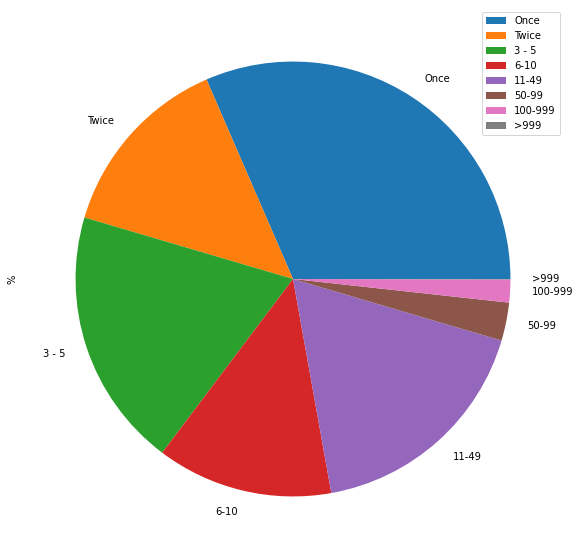

In [46]:
df_times.plot.pie(y = '%', figsize=(10, 10))
# label it!!

##### Selecting tags for tracks with multiple dominant genres

For tracks with multiple dominant genres, the most popular genre dominate the track genre and the popularity of a track genre is calculated from the total number of times this genre appears in the MSD. (Assumption made similar to the one in deciding artist genre/ tag popularity)

This could introduce a popularity bias but should be somewhat less biased than artist genre assignment (an artist's genre could be far more diverse than a track's genre and it could be trickier for us to assign a single genre to an artist. On the contrary, assigning one genre to a track sounds a little better)

In [47]:
track_genre_full = df_plot['track_genre_val'].dropna()
track_genre_full = list(track_genre_full.apply(lambda x: list(x.keys())))
track_genre_full = list(itertools.chain(*track_genre_full))
track_genre_dict = Counter((genre for genre in track_genre_full))
genre = pd.DataFrame(list(track_genre_dict.items()),columns = ['genre','count']).sort_values('count', ascending = True)

In [48]:
# rank the genres by the number of times they appear in the MSD track_genre
# For tracks with multiple dominant genres, the most popular genre dominate the track genre
genre['rank'] = genre['count'].rank()

In [49]:
genre_20 = genre.tail(20)

<BarContainer object of 20 artists>

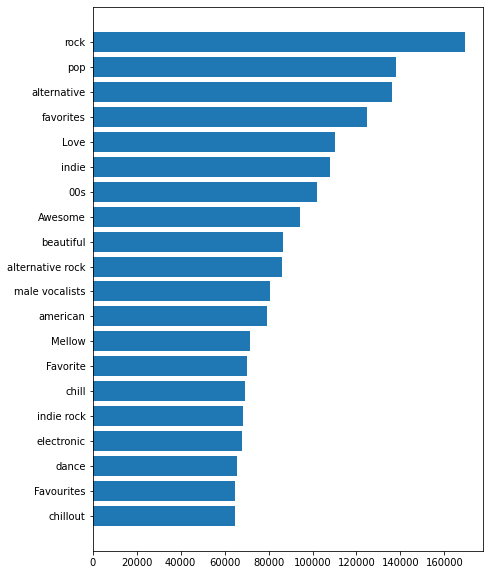

In [50]:
# top 20 most popular genres (by number of times they appear)
x1, y1 = genre_20['genre'], genre_20['count']
fig = plt.figure(figsize = (7,10))
plt.barh(x1,y1)

### Data Cleaning continued (after EDA) for track&artist genres

In this section, we will assign one genre/ tag to each of an artist/ track based on the popularity rankings of the tags made in EDA. The larger the rank, the more popular the tag.

Let's use spark df instead of pd df for the ease of data cleaning.

If there is a tie in the tag rank, ?

In [55]:
import math
#optimizable

def select_tag(track, row):
    """
    inputs: 
        track(boolean):
            True means it is from the track_genre_val column, 
            otherwise artist_mbtag/ artist_term
        row: input row to be cleaned
    return: a dominant genre/ tag for a track/ artist
    """
    if row != row: return row # check for nan rows
    if track:
        genre_lst = find_max_genre(row)
        rank = [int(genre[genre['genre'] == tag]['rank']) for tag in genre_lst]
    else:
        genre_lst = row
        rank = [int(artist_term['rank'][tag]) for tag in row]
    max_index = [idx for idx, val in enumerate(rank) if val == max(rank)]
    dominant_genre = [genre_lst[idx] for idx in max_index]
    return dominant_genre

In [56]:
def find_max_genre(row):
    """
    inputs: 
        row: input row to be cleaned
    return: a list of dominant genre/ tag for a track/ artist
    """
    listOfKeys = list()
    itemMaxValue = max(row.values())
    # Iterate over all the items in dictionary to find keys with max value
    for key, value in row.items():
        if value == itemMaxValue:
            listOfKeys.append(key)
    return listOfKeys

In [ ]:
df_plot['track_genre'] = df_plot['track_genre_val'].apply(lambda x: select_tag(True, x))

In [ ]:
df_plot

In [68]:
df_plot['artist_genre'] = df_plot['artist_term'].apply(lambda x: select_tag(False, x))

In [ ]:
# if tie?

In [ ]:
df_plot

In [55]:
genre

,genre,count,rank
145172,roadtr,1,27017.5
85271,rumpelt,1,27017.5
85270,silent electronica,1,27017.5
85269,chamber electronics,1,27017.5
85268,silent noise,1,27017.5
...,...,...,...
203,Love,110066,290341.0
88,favorites,124823,290342.0
6,alternative,136010,290343.0
4,pop,138087,290344.0


In [70]:
artist_term

,count,rank
0,,
cyprus,1,535.0
bonnaroo 2007,1,535.0
outsider,1,535.0
newcastle,1,535.0
newark,1,535.0
...,...,...
alternative,3650,3627.0
hip hop,3980,3628.0
electronic,5085,3629.0


### UMAP visualization

In [34]:
df_plot.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_genre_val,artist_term,artist_mbtag,user_id,count
0,TRMRSPR128F1486162,Friends (LP Version),SOIASSQ12A6D4FA5A4,Whipped,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussycat,287.81669,0.649822,0.394032,NaN,"{'80s': 25.0, 'rock': 100.0, 'hard rock': 100....","[heavy metal, industrial metal, hard rock, gla...",NaN,f499a469fdf0f01a114eff3ffc45f07eb1038211,1
1,TRWMLGY128F148A1C3,Shooting You Down (LP Version),SOYXZOF12A6D4F96AC,Rhino Hi-Five: Faster Pussycat,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussycat,227.94404,0.649822,0.394032,NaN,"{'rock': 50.0, 'hard rock': 100.0, 'hair metal...","[heavy metal, industrial metal, hard rock, gla...",NaN,565a013a24c2ec710ff6611187389b6b92251bfb,1
2,TRWBHIN128F425A381,Arizona Indian Doll,SOMLCSC12A8C139300,Between The Valley Of The Ultra Pussy,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussycat,265.16853,0.649822,0.394032,1989.0,"{'80s': 27.0, 'rock': 63.0, 'rock n roll': 18....","[heavy metal, industrial metal, hard rock, gla...",NaN,5411bf5ca6fa50a504bce1ef7d44c5f2ae4638ca,1
3,TRHZAVC128F148A1C4,House Of Pain (LP Version),SOSMFOK12A58A7FE92,Rhino Hi-Five: Faster Pussycat,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussycat,344.65914,0.649822,0.394032,NaN,"{'70s': 0.0, '80s': 66.0, 'rock': 100.0, 'meta...","[heavy metal, industrial metal, hard rock, gla...",NaN,8b037ca0e5d30e7ef25b5463b9c82973f5c750ea,1
4,TRHZAVC128F148A1C4,House Of Pain (LP Version),SOSMFOK12A58A7FE92,Rhino Hi-Five: Faster Pussycat,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussycat,344.65914,0.649822,0.394032,NaN,"{'70s': 0.0, '80s': 66.0, 'rock': 100.0, 'meta...","[heavy metal, industrial metal, hard rock, gla...",NaN,297fe67d7b1d8a8b1cdb78ab5239203a39a2a3a0,2


In [ ]:
# id is string type, we change it to int for later join
id_genre_spark_df = id_genre_spark_df.withColumn('id', id_genre_spark_df['id'].cast(IntegerType()))

# explode item factors
itemFactors_exploded = itemFactors.select("id", itemFactors.features[0], itemFactors.features[1], itemFactors.features[2], itemFactors.features[3], itemFactors.features[4], \
                                                itemFactors.features[5], itemFactors.features[6], itemFactors.features[7], itemFactors.features[8], itemFactors.features[9])

id_itemFactor_spark_df = id_genre_spark_df.join(itemFactors_exploded, on = 'id', how = 'inner' )

# extract factors as 10-dimension vectors
data = np.array(id_itemFactor_spark_df.select('features[0]', 'features[1]', 'features[2]', 'features[3]', 'features[4]', 'features[5]', 'features[6]', 'features[7]', 'features[8]', 'features[9]').collect())

# extract labels, some book doesn't have any label so change that to 'none' genre
labels = np.array(['none' if label is None else label for label in [row[0] for row in id_itemFactor_spark_df.select('genre').collect()]])

In [ ]:
start_time = time.time()

In [290]:
mapper = umap.UMAP(random_state=66, n_components=2, verbose = True).fit(df_plot)

NameError: name 'UMAP' is not defined

In [ ]:
umap.plot.points(mapper, labels = sample_labels, theme = 'fire')
plt.savefig('10_0.01_100_percent_400k_66.eps')

In [ ]:
end_time = time.time()

In [ ]:
str(datetime.timedelta(seconds = end_time - start_time))